<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Neural Networks with Momentum</h1>

<h2>Table of Contents</h2>
<p>In this lab, you will see how different values for the momentum parameters affect the convergence rate of a neural network.</p>

<ul>
<li><a href="#Model">Neural Network Module and Function for Training</a></li>
<li><a href="#Train">Train Different Neural Networks Model different values for the Momentum Parameter</a></li>
<li><a href="#Result">Compare Results of Different Momentum Terms</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

<h2>Preparation</h2>

We'll need the following libraries:  

In [1]:
# Import the libraries for this lab

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)
np.random.seed(1)

Functions used to plot:

In [2]:
# Define a function for plot the decision region

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX=torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _,yhat=torch.max(model(XX),1)
    yhat=yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:]==0,0], X[y[:]==0,1], 'ro', label='y=0')
    plt.plot(X[y[:]==1,0], X[y[:]==1,1], 'go', label='y=1')
    plt.plot(X[y[:]==2,0], X[y[:]==2,1], 'o', label='y=2')
    plt.title("decision region")
    plt.legend()

Create the dataset class 

In [3]:
# Create the dataset class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
          y[ix] = j
    
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(),self.x[self.y[:] == 2, 1].numpy(), 'go',label="y=2")
        plt.legend()

<!--Empty Space for separating topics-->

<h2 id="Model">Neural Network Module and Function for Training</h2>

Create Neural Network Module using <code>ModuleList()</code>

In [4]:
# Create dataset object

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))    
            else:
                activation = linear_transform(activation)
        return activation

Create the function for training the model.

In [5]:
# Define the function for training the model

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        LOSS.append(loss.item())
        ACC.append(accuracy(model,data_set))
        
    results ={"Loss":LOSS, "Accuracy":ACC}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return results

Define a function used to calculate accuracy.

In [6]:
# Define a function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

<!--Empty Space for separating topics-->

<h2 id="Train">Train Different Networks Model different values for the Momentum Parameter</h2>

Crate a dataset object using <code>Data</code>

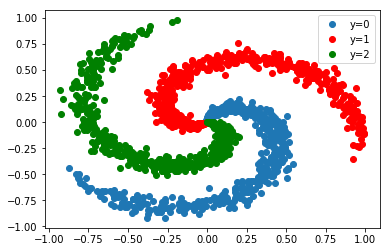

In [7]:
# Create the dataset and plot it

data_set = Data()
data_set.plot_data()
data_set.y = data_set.y.view(-1)

Dictionary to contain different cost and  accuracy values for each epoch  for different values of the momentum parameter.

In [8]:
# Initialize a dictionary to contain the cost and accuracy

Results = {"momentum 0": {"Loss": 0, "Accuracy:": 0}, "momentum 0.1": {"Loss": 0, "Accuracy:": 0}}

Create a  network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of zero.

In [ ]:
# Train a model with 1 hidden layer and 50 neurons

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.1.




In [ ]:
# Train a model with 1 hidden layer and 50 neurons with 0.1 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.1"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)


Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.2.

In [ ]:
# Train a model with 1 hidden layer and 50 neurons with 0.2 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.2"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.4.

In [ ]:
# Train a model with 1 hidden layer and 50 neurons with 0.4 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.4)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.4"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

Create a network to classify three classes with 1 hidden layer with 50 neurons and a momentum value of 0.5.

In [ ]:
# Train a model with 1 hidden layer and 50 neurons with 0.5 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.5"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model,data_set)

<!--Empty Space for separating topics-->

<h2 id="Result">Compare Results of Different Momentum Terms</h2>

The plot below compares results of different momentum terms. We see that in general. The Cost decreases proportionally to the momentum term, but larger momentum terms lead to larger oscillations. While the momentum term decreases faster, it seems that a momentum term of 0.2 reaches the smallest value for the cost. 

In [ ]:
# Plot the Loss result for each term

for key, value in Results.items():
    plt.plot(value['Loss'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

The  accuracy seems to be proportional to the momentum term.

In [ ]:
# Plot the Accuracy result for each term

for key, value in Results.items():
    plt.plot(value['Accuracy'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.